1. Inisialisasi Datasets

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import math
from functools import cmp_to_key

# Inisialisasi datasets
data = datasets.load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = pd.DataFrame(data.target)

2. Hasil Visualisasi Convex Hull dari Library Scipy

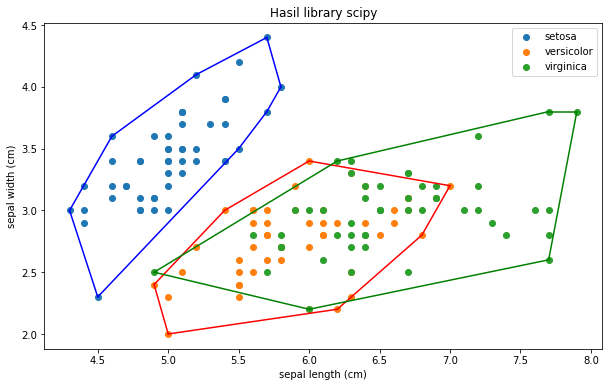

In [11]:
# Visualisasi hasil convex hull dari library scipy
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title("Hasil library scipy")
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
  bucket = df[df['Target'] == i]
  bucket = bucket.iloc[:,[0,1]].values
  hull = ConvexHull(bucket)
  plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
  for simplex in hull.simplices:
    plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()

3. Realisasi Fungsi dan Prosedur serta Inisialisasi Variabel Global

In [15]:
# Inisialisasi variabel global
listpoint=[]
bucket=[]
pivot=[0,0]
prio=[]

# Fungsi untuk menentukan orientasi p3 terhadap garis p1p2
def det(p1,p2,p3):
  return p1[0]*p2[1]+p3[0]*p1[1]+p2[0]*p3[1]-p3[0]*p2[1]-p2[0]*p1[1]-p1[0]*p3[1]

# Fungsi untuk menghitung jarak titik p3 ke garis p1p2
def dist(p1,p2,p3):
  a=((p3[0]-p1[0])**2+(p3[1]-p1[1])**2)**0.5
  b=((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5
  c=((p3[0]-p2[0])**2+(p3[1]-p2[1])**2)**0.5
  s=(a+b+c)/2
  return ((s*(s-a)*(s-b)*(s-c))**0.5)*2/b

# Fungsi untuk menghitung sudut pada p1 dari segitiga p1p2p3
def angle(p1,p2,p3):
  a=((p3[0]-p1[0])**2+(p3[1]-p1[1])**2)**0.5
  b=((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)**0.5
  c=((p3[0]-p2[0])**2+(p3[1]-p2[1])**2)**0.5
  if((a**2+b**2-c**2)/(2*a*b)>1):
    return math.acos(1)
  elif((a**2+b**2-c**2)/(2*a*b)<-1):
    return math.acos(-1)
  return math.acos((a**2+b**2-c**2)/(2*a*b))

# Fungsi untuk mencari p3 yang memiliki jarak maksimum dari garis p1p2
# Jika terdapat beberapa titik yang jaraknya sama akan diambil yang memiliki sudut terbesar
def cmp(p1,p2,p3,curdist,curang):
  dis=dist(p1,p2,p3)
  ang=angle(p3,p1,p2)
  if(dis>curdist or (dis==curdist and ang>curang)):
    return True
  else:
    return False

# Fungsi untuk mengecek apakah sebuah titik p berada di dalam segitiga p1p2p3
def insideTriangle(p1,p2,p3,p):
  return not((det(p1,p2,p)>0 or det(p2,p3,p)>0 or det(p3,p1,p)>0) and (det(p1,p2,p)<0 or det(p2,p3,p)<0 or det(p3,p1,p)<0))

# Fungsi untuk menghitung sudut dari p2 relatif terhadap origin p1
def getangle(p1,p2):
  dx=p2[0]-p1[0]
  dy=p2[1]-p1[1]
  if(dx==0):
    if(dy>0):
      return math.pi/2
    else:
      return 3*math.pi/2
  elif(dx>0 and dy>=0):
    return math.atan(dy/dx)
  elif(dx<0 and dy>=0):
    return math.atan(dy/dx)+math.pi
  elif(dx>0 and dy<0):
    return math.atan(dy/dx)+math.pi*2
  else:
    return math.atan(dy/dx)+math.pi

# Fungsi sebagai parameter untuk mengurutkan titik pada convex hull berdasarkan besar sudutnya terhadap pivot
def getprio(a,b):
  global pivot,bucket
  return getangle(pivot,bucket[a])-getangle(pivot,bucket[b])

# Fungsi yang digunakan untuk Divide and Conquer permasalahan
def solve(arr,c1,c2,orientation):
  global bucket,listpoint
  nextarr=[]

  # Masukkan titik yang orientasinya sama dengan orientation
  for i in range(len(arr)):
    if(arr[i]==c1 or arr[i]==c2):
      continue
    if(det(bucket[c1],bucket[c2],bucket[arr[i]])<0 and orientation<0):
      nextarr.append(arr[i])
    elif(det(bucket[c1],bucket[c2],bucket[arr[i]])>0 and orientation>0):
      nextarr.append(arr[i])
  
  # Basis terjadi jika tidak ada titik yang memenuhi lagi
  if(len(nextarr)==0):
    return
  
  # Cari titik yang memiliki jarak maksimum terhadap garis c1c2
  nextpoint=nextarr[0]
  curdist=dist(bucket[c1],bucket[c2],bucket[nextpoint])
  curang=angle(bucket[c1],bucket[c2],bucket[nextpoint])
  for i in range(1,len(nextarr)):
    if(cmp(bucket[c1],bucket[c2],bucket[nextarr[i]],curdist,curang)):
      nextpoint=nextarr[i]
      curdist=dist(bucket[c1],bucket[c2],bucket[nextpoint])
      curang=angle(bucket[c1],bucket[c2],bucket[nextpoint])
  
  passarr=[]
  # Untuk pemanggilan fungsi rekursi selanjutnya, ambil seluruh titik yang berada di
  # luar segitiga c1c2nextpoint
  for i in range(len(nextarr)):
    if(not(insideTriangle(bucket[c1],bucket[c2],bucket[nextpoint],bucket[nextarr[i]]))):
      passarr.append(nextarr[i])
  # Catat nextpoint pada array listpoint dan lakukan proses rekursi selanjutnya
  listpoint.append(nextpoint)
  solve(passarr,c1,nextpoint,-det(bucket[c1],bucket[nextpoint],bucket[c2]))
  solve(passarr,nextpoint,c2,-det(bucket[nextpoint],bucket[c2],bucket[c1]))

def convex_hull():
  global listpoint,bucket,pivot
  mnm=0
  mxm=0

  # Cari titik yang memiliki absis minimum dan titik yang memiliki absis maksimums
  for i in range(1,len(bucket)):
    if(bucket[mnm][0]<bucket[i][0]):
      mnm=i
    if(bucket[mxm][0]>bucket[i][0]):
      mxm=i
  listpoint.append(mnm)
  listpoint.append(mxm)

  a=[i for i in range(len(bucket))]
  b=[i for i in range(len(bucket))]

  # Lakukan pencarian titik convex hull untuk kedua orientasi dari garis mnm mxm
  solve(a,mnm,mxm,1)
  solve(b,mnm,mxm,-1)

  res=[]
  listpoint=list(dict.fromkeys(listpoint))
  pivot=[(bucket[mnm][0]+bucket[mxm][0])/2,(bucket[mnm][1]+bucket[mxm][1])/2]
  prio=[getangle(pivot,bucket[listpoint[i]]) for i in range(len(listpoint))]

  # Urutkan titik convex hull berdasarkan sudutnya terhadap pivot
  listpoint=sorted(listpoint,key=cmp_to_key(getprio))

  # Hubungkan titik yang saling bertetangga serta titik pertama dan terakhir pada convex hull
  for i in range(1,len(listpoint)):
    res.append([listpoint[i-1],listpoint[i]])
  res.append([listpoint[len(listpoint)-1],listpoint[0]])
  return res

4. Hasil Visualisasi Convex Hull dari Program Utama

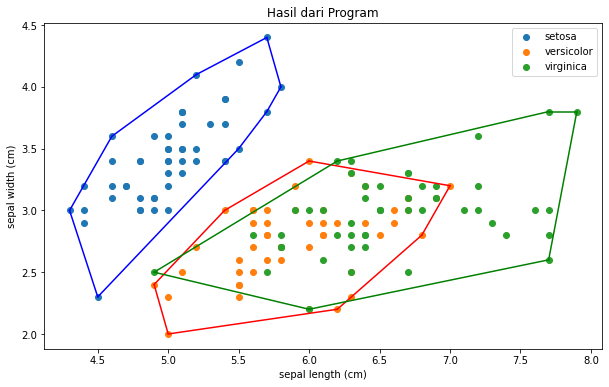

In [16]:
# Visualisasi hasil convex hull dari program yang dibuat
plt.figure(figsize = (10, 6))
colors = ['b','r','g']
plt.title("Hasil dari Program")
plt.xlabel(data.feature_names[0])
plt.ylabel(data.feature_names[1])
for i in range(len(data.target_names)):
  bucket = df[df['Target'] == i]
  bucket = bucket.iloc[:,[0,1]].values
  hull = convex_hull() 
  prio=[]
  listpoint=[]
  plt.scatter(bucket[:, 0], bucket[:, 1], label=data.target_names[i])
  for simplex in hull:
    plt.plot(bucket[simplex, 0], bucket[simplex, 1], colors[i])
plt.legend()
plt.show()
